### Imports:

In [ ]:
from pyspark.sql import SparkSession, Row
from pyspark.sql import functions as F
import igraph as ig
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
import glob
import time
import random


### Settings:

In [2]:
# Default settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Spark session
spark = SparkSession.builder \
    .appName("RedditDepressionAnalysis") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "16g") \
    .config("spark.driver.maxResultSize", "4g") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.default.parallelism", "200") \
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/12/18 20:00:15 WARN Utils: Your hostname, cachyos, resolves to a loopback address: 127.0.1.1; using 192.168.1.236 instead (on interface wlan0)
25/12/18 20:00:15 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/18 20:00:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Loading data:

In [3]:
submissions = spark.read.json("depression_submissions")
comments = spark.read.json("depression_comments")

submissions.show(5)
comments.show(5)

25/12/18 20:00:33 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-----+-------------+-------------------+---------------+-----------+--------+-----------+--------------+------------------+-----------------------------+----------------------+---------------------+------------------------+-----------------+-----------------------+-----------------+---------------+-----------------+--------------------+--------------+--------+-------------+---------+----------+--------------+--------+------------+--------+-------+------------------+------------+-------+-----------+----------------+---------------------+---------------+-------------+---------------+-----+------+----+-------+---------+------+--------+------+----------+-----+----------------------+----------------+-------+-------------------+----------------------+------------------+-------+--------+-----+---------------------------+--------------------+-------------------+----------------------+---------------+---------------------+---------------+------+-----+--------------------+----------+--------+--

* Too many useless columns! 
* We pick what's important for us.

---

## Data Cleaning

### Comments:

In [4]:
comments = comments.select("id", "author", "created_utc", "parent_id", "link_id", "score")
comments.show(10)

+----+-----------+-----------+---------+--------+-----+
|  id|     author|created_utc|parent_id| link_id|score|
+----+-----------+-----------+---------+--------+-----+
|7xa0|HappyRabbit| 1230776046| t3_7mqdw|t3_7mqdw|    1|
|7y9n|  [deleted]| 1230780294| t3_7mqo7|t3_7mqo7|    3|
|7zel|  [deleted]| 1230786613| t3_7mqur|t3_7mqur|    1|
|7zgf|     cluuxz| 1230786885| t3_7mqyx|t3_7mqyx|    5|
|7zgn|    cfabbro| 1230786916| t3_7mqur|t3_7mqur|    6|
|7zo9| Ostrich159| 1230788123| t3_7mqo7|t3_7mqo7|    6|
|7zxq|redmosquito| 1230789682|  t1_7zgf|t3_7mqyx|    3|
|7zyg|    simmias| 1230789820| t3_7mqur|t3_7mqur|    7|
|802k|      Sawta| 1230790554| t3_7mqyx|t3_7mqyx|    6|
|813r| Ostrich159| 1230796786|  t1_7zgf|t3_7mqyx|    4|
+----+-----------+-----------+---------+--------+-----+
only showing top 10 rows


We see that:
* direct comment to the post have the same link_id and parent_id starting with "t3_"
* replies to other comments have a parent_id starting with "t1_" and ends with the id of the parent comment
* we can use the parent_id prefix type and get red of the the columns link_id and score
* for embedded comments we know the author of the parent comment but for direct comments we dont know the submitter that they are interracted with
* we can join with the submissions to get that information and build our graph
* for the created_utc column we need to transform it into something human readable

In [5]:
# Deleting the link_id and score columns
comments = comments.select("id", "author", "created_utc", "parent_id")

# transforming the created_utc column
# first we cast the column into a long
comments = comments.withColumn("created_utc", F.col("created_utc").cast("double").cast("long"))

comments = comments.withColumn("year", F.year(F.from_unixtime("created_utc").cast("timestamp"))) \
       .withColumn("month", F.month(F.from_unixtime("created_utc").cast("timestamp"))) \
       .withColumn("day", F.dayofmonth(F.from_unixtime("created_utc").cast("timestamp")))

comments.orderBy(F.col("created_utc").desc()).show(10)

+-------+-----------------+-----------+----------+----+-----+---+
|     id|           author|created_utc| parent_id|year|month|day|
+-------+-----------------+-----------+----------+----+-----+---+
|m4rvixo|      fmylife2024| 1735689484|t1_m4rv20i|2025|    1|  1|
|m4rv3xo|     Unreal_catto| 1735689327|t3_1hqevuc|2025|    1|  1|
|m4rv20i|Fabulous_Owl_8471| 1735689307|t1_m4ruqba|2025|    1|  1|
|m4rv1ox|        [deleted]| 1735689304|t3_1frqlk0|2025|    1|  1|
|m4ruqba|      fmylife2024| 1735689184|t1_m4rrqqh|2025|    1|  1|
|m4ru0xd|     Nutsyblazzer| 1735688918|t1_m4r70da|2025|    1|  1|
|m4rtwm7| Single_Berry7546| 1735688872|t1_m4rpwi1|2025|    1|  1|
|m4rtuzw|Fabulous_Owl_8471| 1735688855|t3_1hqnkkr|2025|    1|  1|
|m4rtm0a| Single_Berry7546| 1735688761|t1_m4rm736|2025|    1|  1|
|m4rthad|   tarteframboise| 1735688712|t3_1hqqtay|2025|    1|  1|
+-------+-----------------+-----------+----------+----+-----+---+
only showing top 10 rows


### Submissions:

In [6]:
submissions = submissions.select("id", "author", "created_utc", "score", "num_comments")
submissions.show(10)

+-----+-----------+-----------+-----+------------+
|   id|     author|created_utc|score|num_comments|
+-----+-----------+-----------+-----+------------+
|7mqco|  [deleted]| 1230773002|    1|           0|
|7mqdw|HappyRabbit| 1230773772|    1|           1|
|7mqo7|  [deleted]| 1230780179|    7|           2|
|7mqur|  [deleted]| 1230784330|    6|           7|
|7mqyx|  [deleted]| 1230786778|    7|          11|
|7mr2a| Ostrich159| 1230788514|    4|           0|
|7mrbw|  [deleted]| 1230794035|    7|           1|
|7mrg3|  [deleted]| 1230796700|    9|           7|
|7mrp0| OctopusMan| 1230802690|   12|          14|
|7mru2|   i_love_u| 1230806086|    1|           0|
+-----+-----------+-----------+-----+------------+
only showing top 10 rows


* For the submissions we dont need the columns created_utc, score, num_comments
* the dataframe is needed only for joining to find the submission author

In [7]:
submissions = submissions.select("id", "author")
submissions.show(5)

+-----+-----------+
|   id|     author|
+-----+-----------+
|7mqco|  [deleted]|
|7mqdw|HappyRabbit|
|7mqo7|  [deleted]|
|7mqur|  [deleted]|
|7mqyx|  [deleted]|
+-----+-----------+
only showing top 5 rows


### Graph dataframe:

In [8]:
comments_to_posts = comments.filter(F.col("parent_id").startswith("t3_")) \
    .withColumn("post_id", F.regexp_replace(F.col("parent_id"), "^t3_", "")) \
    .join(submissions, F.col("post_id") == submissions["id"], "inner") \
    .select(
        comments["author"].alias("source"),
        submissions["author"].alias("target"),
        comments["created_utc"].alias("timestamp"),
        F.lit("comment_on_post").alias("interaction_type"),
        comments["year"],
        comments["month"],
        comments["day"]
    )

comments_to_posts.show(5)

+-------------+-------------------+----------+----------------+----+-----+---+
|       source|             target| timestamp|interaction_type|year|month|day|
+-------------+-------------------+----------+----------------+----+-----+---+
| DedInside50s|         27Club2023|1672533471| comment_on_post|2023|    1|  1|
| youlackfacts|         27Club2023|1672534825| comment_on_post|2023|    1|  1|
|   Weary-Lime|Hatelovedemonslayer|1672543313| comment_on_post|2023|    1|  1|
|radish_recoup|Hatelovedemonslayer|1672579363| comment_on_post|2023|    1|  1|
|    irinirinn|         sad_apple5|1672565992| comment_on_post|2023|    1|  1|
+-------------+-------------------+----------+----------------+----+-----+---+
only showing top 5 rows


In [9]:
comment_replies = comments.filter(F.col("parent_id").startswith("t1_")) \
    .withColumn("parent_comment_id", F.regexp_replace(F.col("parent_id"), "^t1_", "")) \
    .alias("c1") \
    .join(comments.alias("c2"), F.col("c1.parent_comment_id") == F.col("c2.id"), "inner") \
    .select(
        F.col("c1.author").alias("source"),
        F.col("c2.author").alias("target"),
        F.col("c1.created_utc").alias("timestamp"),
        F.lit("comment_on_comment").alias("interaction_type"),
        F.col("c1.year"),
        F.col("c1.month"),
        F.col("c1.day")
    )

comment_replies.show(5)

+----------+--------------+----------+------------------+----+-----+---+
|    source|        target| timestamp|  interaction_type|year|month|day|
+----------+--------------+----------+------------------+----+-----+---+
| [deleted]|IheartDaRegion|1237915656|comment_on_comment|2009|    3| 24|
| [deleted]|      bluegerm|1254096044|comment_on_comment|2009|    9| 28|
|sickasabat|     [deleted]|1266596772|comment_on_comment|2010|    2| 19|
|    soitis|        mvoewf|1267353088|comment_on_comment|2010|    2| 28|
| [deleted]|        rymmen|1270956588|comment_on_comment|2010|    4| 11|
+----------+--------------+----------+------------------+----+-----+---+
only showing top 5 rows


In [10]:
edges = comments_to_posts.union(comment_replies) \
    .filter((F.col("source") != "[deleted]") & (F.col("target") != "[deleted]") & (F.col("source") != F.col("target")) & (F.col("year") < 2025)) \
    .orderBy("timestamp")

edges.show(10)

+-------------+----------+----------+------------------+----+-----+---+
|       source|    target| timestamp|  interaction_type|year|month|day|
+-------------+----------+----------+------------------+----+-----+---+
|  redmosquito|    cluuxz|1230789682|comment_on_comment|2009|    1|  1|
|   Ostrich159|    cluuxz|1230796786|comment_on_comment|2009|    1|  1|
|     cujo3017|    cluuxz|1230800681|comment_on_comment|2009|    1|  1|
|bobkingof12vs|OctopusMan|1230805754|comment_on_comment|2009|    1|  1|
|bobkingof12vs|  i_love_u|1230807596|   comment_on_post|2009|    1|  1|
|     g2petter|OctopusMan|1230812559|comment_on_comment|2009|    1|  1|
|   julenissen|OctopusMan|1230816912|comment_on_comment|2009|    1|  1|
|      lemming|OctopusMan|1230833115|comment_on_comment|2009|    1|  1|
|         mmmf|    cluuxz|1230845741|comment_on_comment|2009|    1|  1|
|ThatOtherGirl|OctopusMan|1231130231|comment_on_comment|2009|    1|  5|
+-------------+----------+----------+------------------+----+---

---

## Data Exploration

In [11]:
cmt_on_cmt_count = comment_replies.count()
cmt_on_pst_count = comments_to_posts.count()

total = cmt_on_cmt_count + cmt_on_pst_count
final = edges.count()
deleted = total - final  
deleted_prct = (deleted/total)*100

print(f"Total interactions: {total}")
print(f"After filtering deleted users: {final}")
print(f"Deleted interactions: {deleted}")
print(f"Deleted percentage: {deleted_prct:.2f}%")

Total interactions: 6377886
After filtering deleted users: 4116812
Deleted interactions: 2261074
Deleted percentage: 35.45%


In [12]:
# Compute statistics per year using Spark
yearly_stats = edges.groupBy('year').agg(
    F.count('*').alias('num_edges'),
    F.countDistinct('source').alias('num_sources'),
    F.countDistinct('target').alias('num_targets'),
    F.countDistinct(F.concat('source', 'target')).alias('unique_pairs')
).orderBy('year')

# Compute total unique users per year (union of sources and targets)
users_per_year = edges.groupBy('year').agg(
    F.countDistinct(F.array('source', 'target')).alias('temp')
)

# Better approach: union sources and targets
sources = edges.select('year', F.col('source').alias('user'))
targets = edges.select('year', F.col('target').alias('user'))
unique_users_per_year = sources.union(targets)\
    .groupBy('year')\
    .agg(F.countDistinct('user').alias('num_unique_users'))\
    .orderBy('year')

# Join the statistics
yearly_stats = yearly_stats.join(unique_users_per_year, on='year', how='left')

In [13]:
# Show sample
print("Yearly Statistics Preview:")
yearly_stats.orderBy("year").show(truncate=False)

Yearly Statistics Preview:


+----+---------+-----------+-----------+------------+----------------+
|year|num_edges|num_sources|num_targets|unique_pairs|num_unique_users|
+----+---------+-----------+-----------+------------+----------------+
|2009|721      |213        |173        |549         |255             |
|2010|8525     |2145       |1798       |6721        |2551            |
|2011|27164    |6895       |5914       |21977       |8342            |
|2012|91852    |19695      |16982      |71668       |23557           |
|2013|132251   |31438      |27466      |102740      |38167           |
|2014|159839   |38317      |34686      |124411      |46941           |
|2015|258452   |52956      |47995      |205018      |64216           |
|2016|340632   |63587      |55676      |275469      |76105           |
|2017|459203   |78518      |67434      |362710      |92700           |
|2018|501110   |96115      |81217      |396571      |113274          |
|2019|568433   |119209     |98910      |449891      |140128          |
|2020|

### General statistics visualization:

In [14]:
# Collect to Pandas (small data - only 17 rows)
df_yearly = yearly_stats.toPandas()
df_yearly = df_yearly.sort_values("year").reset_index(drop=True)
# Calculate derived metrics
df_yearly['avg_degree'] = (2 * df_yearly['num_edges']) / df_yearly['num_unique_users']
df_yearly['density'] = df_yearly['num_edges'] / (df_yearly['num_unique_users'] * (df_yearly['num_unique_users'] - 1))

# Format density as percentage for readability
df_yearly['density_pct'] = df_yearly['density'] * 100

# Display the complete table
print("\n" + "="*80)
print("COMPLETE YEARLY STATISTICS")
print("="*80)
print(df_yearly.to_string(index=False))
print("="*80)


COMPLETE YEARLY STATISTICS
 year  num_edges  num_sources  num_targets  unique_pairs  num_unique_users  avg_degree  density  density_pct
 2009        721          213          173           549               255    5.654902 0.011132     1.113170
 2010       8525         2145         1798          6721              2551    6.683653 0.001311     0.131052
 2011      27164         6895         5914         21977              8342    6.512587 0.000390     0.039040
 2012      91852        19695        16982         71668             23557    7.798277 0.000166     0.016553
 2013     132251        31438        27466        102740             38167    6.930123 0.000091     0.009079
 2014     159839        38317        34686        124411             46941    6.810209 0.000073     0.007254
 2015     258452        52956        47995        205018             64216    8.049458 0.000063     0.006268
 2016     340632        63587        55676        275469             76105    8.951633 0.000059     

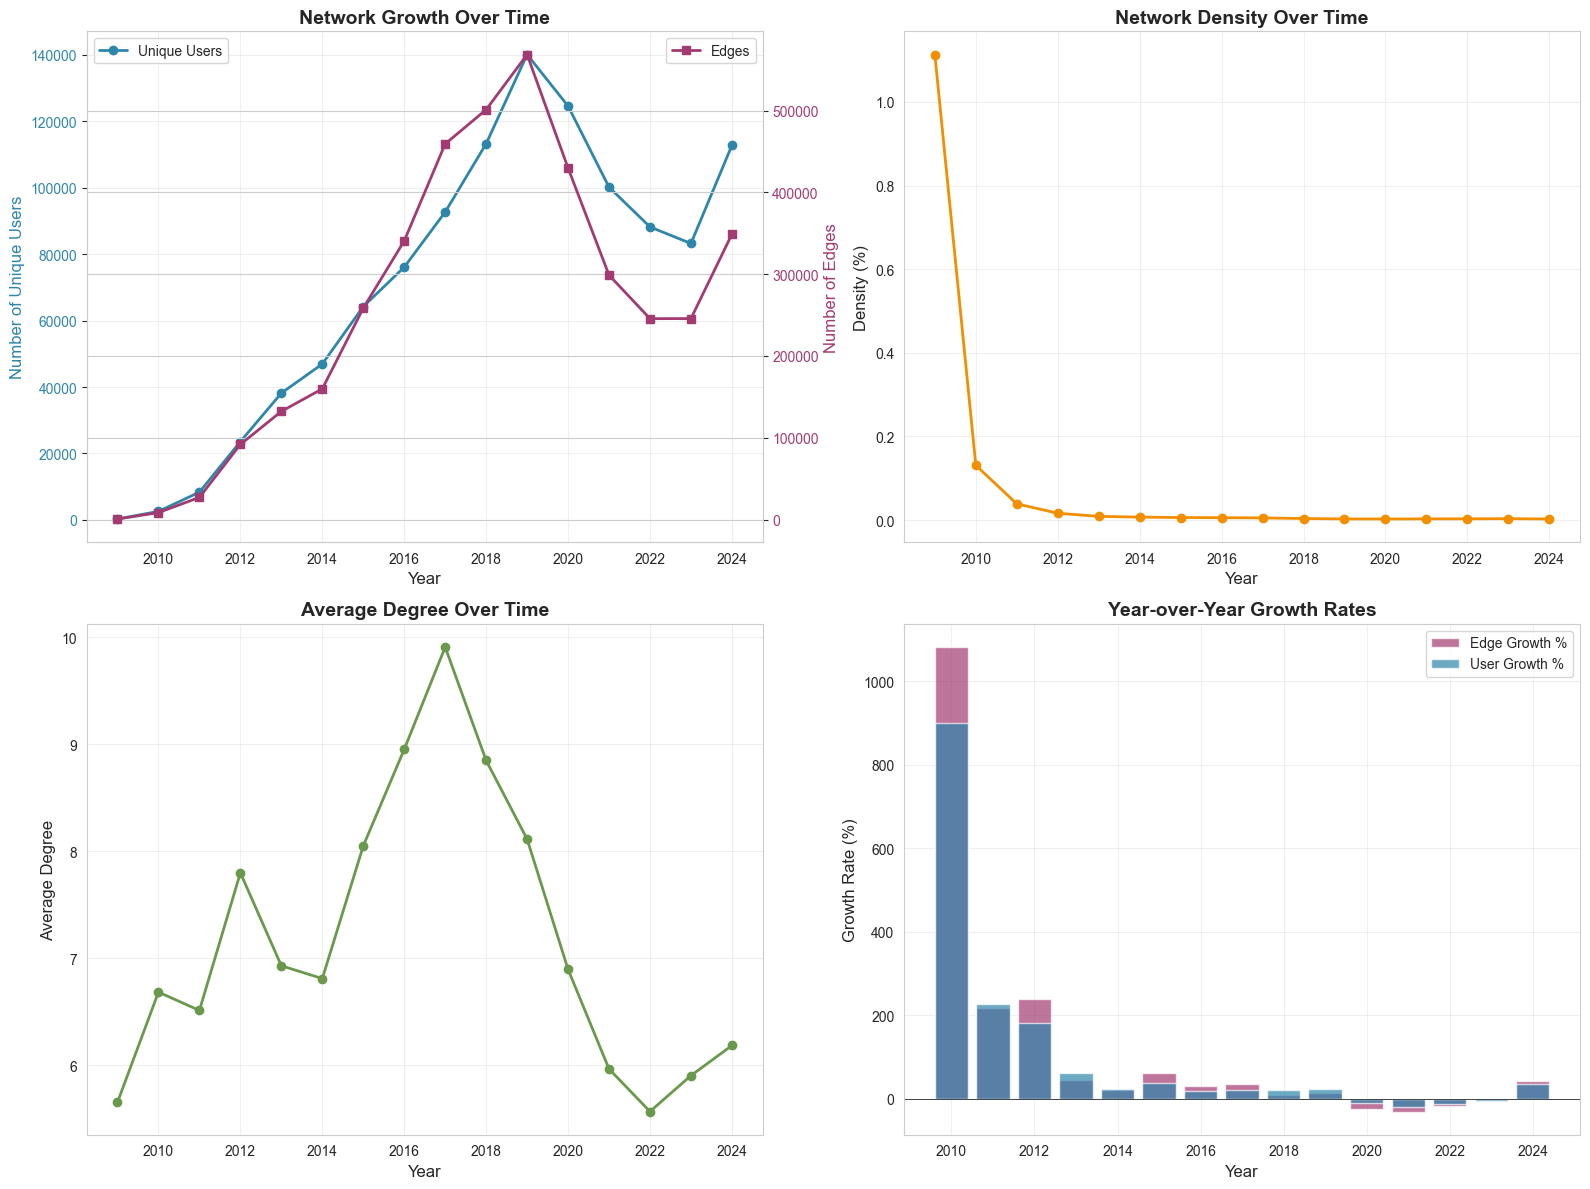


Visualization saved as 'network_evolution_overview.png'


In [15]:
# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Network Growth (Nodes and Edges)
ax1 = axes[0, 0]
ax1_twin = ax1.twinx()

ax1.plot(df_yearly['year'], df_yearly['num_unique_users'], 
         marker='o', linewidth=2, markersize=6, color='#2E86AB', label='Unique Users')
ax1_twin.plot(df_yearly['year'], df_yearly['num_edges'], 
              marker='s', linewidth=2, markersize=6, color='#A23B72', label='Edges')

ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Number of Unique Users', fontsize=12, color='#2E86AB')
ax1_twin.set_ylabel('Number of Edges', fontsize=12, color='#A23B72')
ax1.tick_params(axis='y', labelcolor='#2E86AB')
ax1_twin.tick_params(axis='y', labelcolor='#A23B72')
ax1.set_title('Network Growth Over Time', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper left')
ax1_twin.legend(loc='upper right')

# Plot 2: Density Evolution
ax2 = axes[0, 1]
ax2.plot(df_yearly['year'], df_yearly['density_pct'], 
         marker='o', linewidth=2, markersize=6, color='#F18F01')
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Density (%)', fontsize=12)
ax2.set_title('Network Density Over Time', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Plot 3: Average Degree
ax3 = axes[1, 0]
ax3.plot(df_yearly['year'], df_yearly['avg_degree'], 
         marker='o', linewidth=2, markersize=6, color='#6A994E')
ax3.set_xlabel('Year', fontsize=12)
ax3.set_ylabel('Average Degree', fontsize=12)
ax3.set_title('Average Degree Over Time', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Plot 4: Year-over-Year Growth Rate
ax4 = axes[1, 1]
df_yearly['edge_growth_pct'] = df_yearly['num_edges'].pct_change() * 100
df_yearly['user_growth_pct'] = df_yearly['num_unique_users'].pct_change() * 100

ax4.bar(df_yearly['year'][1:], df_yearly['edge_growth_pct'][1:], 
        alpha=0.7, label='Edge Growth %', color='#A23B72')
ax4.bar(df_yearly['year'][1:], df_yearly['user_growth_pct'][1:], 
        alpha=0.7, label='User Growth %', color="#2E86AB")
ax4.set_xlabel('Year', fontsize=12)
ax4.set_ylabel('Growth Rate (%)', fontsize=12)
ax4.set_title('Year-over-Year Growth Rates', fontsize=14, fontweight='bold')
ax4.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('network_evolution_overview.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualization saved as 'network_evolution_overview.png'")

---

## Yearly graph snapshots

### Graphs directory:

In [16]:
output_dir = 'yearly_graphs'
os.makedirs(output_dir, exist_ok=True)

print(f"Output directory created: {output_dir}/")

Output directory created: yearly_graphs/


### Graph export:

In [ ]:
years_to_export = range(2009, 2025) # from 2009 to 2024

print("Starting export of yearly edge lists...")
print("="*80)

export_summary = []

for year in years_to_export:
    # Filter by year
    year_edges = edges.filter(F.col('year') == year)
    
    # Edge count
    edge_count = year_edges.count()
    
    # Important columns selection
    year_edges.select('source', 'target', 'timestamp', 'interaction_type') \
        .coalesce(1) \
        .write.mode('overwrite') \
        .option('header', 'true') \
        .csv(f'{output_dir}/temp_{year}')
    
    # Summary
    export_summary.append({
        'year': year,
        'edges': edge_count
    })
    
    print(f"Year {year}: {edge_count:,} edges exported")

print("="*80)
print("All years exported successfully!")

Starting export of yearly edge lists...


Year 2009: 721 edges exported


Year 2010: 8,525 edges exported


Year 2011: 27,164 edges exported


Year 2012: 91,852 edges exported


ERROR:root:KeyboardInterrupt while sending command.0][Stage 307:>(0 + 0) / 200]
Traceback (most recent call last):
  File "/home/sora/Git/reddit-depression-dynamic-graph-analysis/.venv/lib/python3.13/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/sora/Git/reddit-depression-dynamic-graph-analysis/.venv/lib/python3.13/site-packages/py4j/clientserver.py", line 535, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ~~~~~~~~~~~~~~~~~~~~^^
  File "/usr/lib/python3.13/socket.py", line 719, in readinto
    return self._sock.recv_into(b)
           ~~~~~~~~~~~~~~~~~~~~^^^
KeyboardInterrupt


KeyboardInterrupt: 

### Optional renaming:

Spark doesn't save dataframes with cleanly like pandas so we need to do all the work manually.

In [ ]:
print("\nCleaning up file structure...")

for year in years_to_export:
    temp_dir = f'{output_dir}/temp_{year}'
    
    # Find the actual CSV file (Spark names it part-xxxxx.csv)
    csv_files = glob.glob(f'{temp_dir}/part-*.csv')
    
    if csv_files:
        # Rename to clean filename
        final_filename = f'{output_dir}/edges_{year}.csv'
        shutil.move(csv_files[0], final_filename)
        
        # Remove temp directory
        shutil.rmtree(temp_dir)
        
print("File structure cleaned up!")


Cleaning up file structure...
File structure cleaned up!


---

# Graph Building

In [18]:
# Choose test year
test_year = 2019

print(f"Loading graph for year {test_year}...")

# Load edge list from CSV
edges_file = f'yearly_graphs/edges_{test_year}.csv'
df_edges = pd.read_csv(edges_file)

print(f"Loaded {len(df_edges):,} edges from {edges_file}")

# Create igraph from edge list
# tuples parameter: list of (source, target) tuples
# directed=True: because comments have direction (commenter → recipient)
edge_tuples = list(zip(df_edges['source'], df_edges['target']))

G = ig.Graph.TupleList(edge_tuples, directed=True)

print(f"Graph created successfully!")
print(f"   Nodes: {G.vcount():,}")
print(f"   Edges: {G.ecount():,}")

Loading graph for year 2019...
Loaded 568,433 edges from yearly_graphs/edges_2019.csv
Graph created successfully!
   Nodes: 140,128
   Edges: 568,433


*=>* Note that i have picked a single year for test (2019).

### Basic Metrics:

In [19]:
print("\n" + "="*80)
print(f"NETWORK METRICS FOR YEAR {test_year}")
print("="*80)

# Basic statistics
num_nodes = G.vcount()
num_edges = G.ecount()
density = G.density()

print(f"\n# BASIC STATISTICS:")
print(f"   Nodes (users): {num_nodes:,}")
print(f"   Edges (interactions): {num_edges:,}")
print(f"   Density: {density:.6f} ({density*100:.4f}%)")
print(f"   Directed: {G.is_directed()}")

# Connected components
components = G.connected_components(mode='weak')  # weak = ignore direction
num_components = len(components)
giant_component_size = max(components.sizes())

print(f"\n# CONNECTIVITY:")
print(f"   Number of components: {num_components}")
print(f"   Giant component size: {giant_component_size:,} nodes ({giant_component_size/num_nodes*100:.1f}%)")
print(f"   Isolated nodes: {sum(1 for size in components.sizes() if size == 1)}")

# Degree statistics
degrees_out = G.degree(mode='out')  # out-degree: how many people they comment to
degrees_in = G.degree(mode='in')    # in-degree: how many people comment to them
degrees_all = G.degree(mode='all')  # total degree

print(f"\n# DEGREE STATISTICS:")
print(f"   Average out-degree: {np.mean(degrees_out):.2f}")
print(f"   Average in-degree: {np.mean(degrees_in):.2f}")
print(f"   Average total degree: {np.mean(degrees_all):.2f}")
print(f"   Max out-degree: {max(degrees_out)} (most active commenter)")
print(f"   Max in-degree: {max(degrees_in)} (most replied-to user)")

# Clustering coefficient (computationally expensive, so we'll use transitivity)
transitivity = G.transitivity_undirected()
avg_clustering = G.transitivity_avglocal_undirected()

print(f"\n# CLUSTERING:")
print(f"   Global transitivity: {transitivity:.6f}")
print(f"   Average local clustering: {avg_clustering:.6f}")

# Reciprocity (for directed graphs - mutual connections)
reciprocity = G.reciprocity()
print(f"\n# RECIPROCITY:")
print(f"   Reciprocity: {reciprocity:.6f} ({reciprocity*100:.2f}% of edges are reciprocated)")

print("="*80)


NETWORK METRICS FOR YEAR 2019

# BASIC STATISTICS:
   Nodes (users): 140,128
   Edges (interactions): 568,433
   Density: 0.000029 (0.0029%)
   Directed: True

# CONNECTIVITY:
   Number of components: 2297
   Giant component size: 135,203 nodes (96.5%)
   Isolated nodes: 0

# DEGREE STATISTICS:
   Average out-degree: 4.06
   Average in-degree: 4.06
   Average total degree: 8.11
   Max out-degree: 4683 (most active commenter)
   Max in-degree: 5166 (most replied-to user)

# CLUSTERING:
   Global transitivity: 0.003087
   Average local clustering: 0.042312

# RECIPROCITY:
   Reciprocity: 0.472246 (47.22% of edges are reciprocated)


### Centrality:

In [ ]:
print("\n" + "="*80)
print("CENTRALITY ANALYSIS - TOP INFLUENTIAL USERS")
print("="*80)

# Get node names
node_names = G.vs['name']

# 1. Degree Centrality (most active/popular)
print("\n# TOP 10 USERS BY OUT-DEGREE (Most Active Commenters):")
degree_out = G.degree(mode='out')
top_out = sorted(zip(node_names, degree_out), key=lambda x: x[1], reverse=True)[:10]
for i, (user, deg) in enumerate(top_out, 1):
    print(f"   {i:2d}. {user:30s} - {deg:5d} comments made")

print("\n# TOP 10 USERS BY IN-DEGREE (Most Replied-To):")
degree_in = G.degree(mode='in')
top_in = sorted(zip(node_names, degree_in), key=lambda x: x[1], reverse=True)[:10]
for i, (user, deg) in enumerate(top_in, 1):
    print(f"   {i:2d}. {user:30s} - {deg:5d} comments received")

# 2. PageRank (overall influence)
print("\n# TOP 10 USERS BY PAGERANK (Overall Influence):")
pagerank = G.pagerank()
top_pr = sorted(zip(node_names, pagerank), key=lambda x: x[1], reverse=True)[:10]
for i, (user, pr) in enumerate(top_pr, 1):
    print(f"   {i:2d}. {user:30s} - PageRank: {pr:.6f}")

# 3. Betweenness Centrality (bridges/connectors)
# Note: This is expensive, so we'll compute for a sample 
print("\n=>  Betweenness centrality skipped (computationally expensive for 140k nodes)")
print("   Will compute for smaller years or on a sample")

print("="*80)


CENTRALITY ANALYSIS - TOP INFLUENTIAL USERS

# TOP 10 USERS BY OUT-DEGREE (Most Active Commenters):
    1. AnotherTrowaway12              -  4683 comments made
    2. JesusAndSoda                   -  4161 comments made
    3. maddiokii                      -   722 comments made
    4. EnnazusCB                      -   681 comments made
    5. What_I_do_45                   -   608 comments made
    6. StrongCrypto                   -   603 comments made
    7. treatment32                    -   583 comments made
    8. numberfivedream                -   573 comments made
    9. gibsonh90                      -   512 comments made
   10. Juancervantes22                -   503 comments made

# TOP 10 USERS BY IN-DEGREE (Most Replied-To):
    1. SQLwitch                       -  5166 comments received
    2. circinia                       -  3989 comments received
    3. AnotherTrowaway12              -  2775 comments received
    4. JesusAndSoda                   -  2489 comments rece

In [ ]:
print("\n" + "="*80)
print("BETWEENESS CENTRALITY")
print("="*80)



# Approximate betweenness with cutoff
print("\nComputing approximate betweenness (cutoff=5)...")
start_time = time.time()
betweenness = G.betweenness(directed=True, cutoff=5)
elapsed = time.time() - start_time
print(f"=> Betweenness computed in {elapsed:.1f} seconds")

# 3. Find top nodes
top_n = 10
top_betweenness_idx = sorted(range(num_nodes), key=lambda x: betweenness[x], reverse=True)[:top_n]

print(f"\n# Top {top_n} Most Central Nodes:")


print(f"\nBy Betweenness (bridge position):")
for i, idx in enumerate(top_betweenness_idx, 1):
    print(f"  {i}. Node {idx}: {betweenness[idx]:.2f}")

print("="*80)

### Community detection (lovain):

In [21]:
print("\n" + "="*80)
print("COMMUNITY DETECTION (Louvain Algorithm)")
print("="*80)

# Run Louvain community detection
# Using undirected version for community detection (more standard)
print("Running Louvain algorithm (this may take 1-2 minutes)...")


# Note that i turned the graph into an undirected one
G_undirected = G.as_undirected(mode="collapse", combine_edges="sum")
communities = G_undirected.community_multilevel()

# communities = G.community_multilevel()

num_communities = len(communities)
community_sizes = communities.sizes()

print(f"\n=>Community detection complete!")
print(f"\n# COMMUNITY STATISTICS:")
print(f"   Number of communities: {num_communities}")
print(f"   Modularity: {communities.modularity:.4f}")
print(f"   Largest community: {max(community_sizes):,} members")
print(f"   Smallest community: {min(community_sizes):,} members")
print(f"   Average community size: {np.mean(community_sizes):.1f}")

# Show size distribution
print(f"\n# COMMUNITY SIZE DISTRIBUTION:")
size_bins = [1, 10, 50, 100, 500, 1000, 5000, float('inf')]
size_labels = ['1-9', '10-49', '50-99', '100-499', '500-999', '1000-4999', '5000+']

size_counts = Counter()
for size in community_sizes:
    for i, threshold in enumerate(size_bins[1:]):
        if size < threshold:
            size_counts[size_labels[i]] += 1
            break

for label in size_labels:
    count = size_counts[label]
    if count > 0:
        print(f"   {label:>10s} members: {count:4d} communities")

print("="*80)


COMMUNITY DETECTION (Louvain Algorithm)
Running Louvain algorithm (this may take 1-2 minutes)...

=>Community detection complete!

# COMMUNITY STATISTICS:
   Number of communities: 2599
   Modularity: 0.5183
   Largest community: 27,391 members
   Smallest community: 2 members
   Average community size: 53.9

# COMMUNITY SIZE DISTRIBUTION:
          1-9 members: 2515 communities
        10-49 members:   45 communities
        50-99 members:    1 communities
      100-499 members:   13 communities
      500-999 members:   17 communities
    1000-4999 members:    1 communities
        5000+ members:    7 communities


### Visualisations:

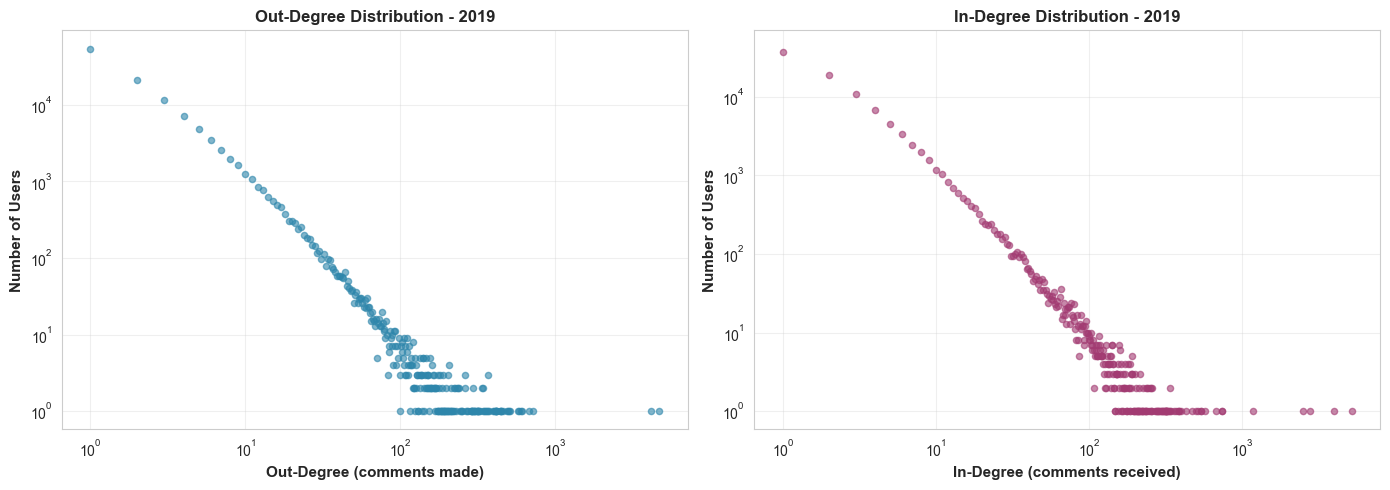


Degree distribution plot saved as 'degree_distribution_2019.png'


In [22]:
# Plot degree distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Out-degree distribution
ax1 = axes[0]
degree_counts_out = Counter(degrees_out)
degrees_sorted = sorted(degree_counts_out.keys())
counts = [degree_counts_out[d] for d in degrees_sorted]

ax1.scatter(degrees_sorted, counts, alpha=0.6, s=20, color='#2E86AB')
ax1.set_xlabel('Out-Degree (comments made)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Number of Users', fontsize=11, fontweight='bold')
ax1.set_title(f'Out-Degree Distribution - {test_year}', fontsize=12, fontweight='bold')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3)

# In-degree distribution
ax2 = axes[1]
degree_counts_in = Counter(degrees_in)
degrees_sorted_in = sorted(degree_counts_in.keys())
counts_in = [degree_counts_in[d] for d in degrees_sorted_in]

ax2.scatter(degrees_sorted_in, counts_in, alpha=0.6, s=20, color='#A23B72')
ax2.set_xlabel('In-Degree (comments received)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Number of Users', fontsize=11, fontweight='bold')
ax2.set_title(f'In-Degree Distribution - {test_year}', fontsize=12, fontweight='bold')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'degree_distribution_{test_year}.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nDegree distribution plot saved as 'degree_distribution_{test_year}.png'")

### Betweeness centrality:

In [24]:
import time

print("Attempting betweenness centrality calculation...")
print("=>  This may take some time for 140k nodes. Watch for progress...")

start_time = time.time()

try:
    # Compute betweenness for all nodes
    betweenness = G.betweenness(directed=True)
    
    elapsed = time.time() - start_time
    print(f"=> Betweenness computed in {elapsed:.1f} seconds ({elapsed/60:.1f} minutes)")
    
    # Get top users by betweenness
    node_names = G.vs['name']
    top_between = sorted(zip(node_names, betweenness), key=lambda x: x[1], reverse=True)[:10]
    
    print("\n=> TOP 10 USERS BY BETWEENNESS (Bridges/Connectors):")
    for i, (user, bet) in enumerate(top_between, 1):
        print(f"   {i:2d}. {user:30s} - Betweenness: {bet:.2f}")
        
except KeyboardInterrupt:
    print("\nX Computation interrupted by user")
    print(f"   Time elapsed: {(time.time() - start_time)/60:.1f} minutes")

Attempting betweenness centrality calculation...
=>  This may take some time for 140k nodes. Watch for progress...

X Computation interrupted by user
   Time elapsed: 0.1 minutes


*=>* This takes a long time so we'll have to go with sampling to get an approximation.  

In [ ]:
print("\n" + "="*80)
print("CENTRALITY MEASURES")
print("="*80)

import time

# 1. Fast metrics
print("Computing fast centrality metrics...")
degree_cent = G.degree()
pagerank = G.pagerank(directed=True)

print("=> Fast metrics computed!")

# 2. Approximate betweenness with cutoff
print("\nComputing approximate betweenness (cutoff=5)...")
start_time = time.time()
betweenness = G.betweenness(directed=True, cutoff=5)
elapsed = time.time() - start_time
print(f"=> Betweenness computed in {elapsed:.1f} seconds")

# 3. Find top nodes
top_n = 10
top_degree_idx = sorted(range(num_nodes), key=lambda x: degree_cent[x], reverse=True)[:top_n]
top_pagerank_idx = sorted(range(num_nodes), key=lambda x: pagerank[x], reverse=True)[:top_n]
top_betweenness_idx = sorted(range(num_nodes), key=lambda x: betweenness[x], reverse=True)[:top_n]

print(f"\n# Top {top_n} Most Central Nodes:")
print(f"\nBy Degree (connections):")
for i, idx in enumerate(top_degree_idx, 1):
    print(f"  {i}. Node {idx}: {degree_cent[idx]} connections")

print(f"\nBy PageRank (importance):")
for i, idx in enumerate(top_pagerank_idx, 1):
    print(f"  {i}. Node {idx}: {pagerank[idx]:.6f}")

print(f"\nBy Betweenness (bridge position):")
for i, idx in enumerate(top_betweenness_idx, 1):
    print(f"  {i}. Node {idx}: {betweenness[idx]:.2f}")

print("="*80)


CENTRALITY MEASURES
Computing fast centrality metrics...
✅ Fast metrics computed!

Computing approximate betweenness (cutoff=5)...
✅ Betweenness computed in 1150.7 seconds

📊 Top 10 Most Central Nodes:

By Degree (connections):
  1. Node 177: 7458 connections
  2. Node 69565: 6650 connections
  3. Node 46: 5517 connections
  4. Node 5210: 4103 connections
  5. Node 105604: 1255 connections
  6. Node 1093: 1155 connections
  7. Node 821: 1149 connections
  8. Node 64114: 1081 connections
  9. Node 17279: 961 connections
  10. Node 487: 960 connections

By PageRank (importance):
  1. Node 46: 0.005848
  2. Node 5210: 0.004594
  3. Node 69565: 0.003720
  4. Node 177: 0.003482
  5. Node 126399: 0.002387
  6. Node 132700: 0.002031
  7. Node 105604: 0.001869
  8. Node 1093: 0.000897
  9. Node 64114: 0.000838
  10. Node 640: 0.000788

By Betweenness (bridge position):
  1. Node 177: 1253628857.75
  2. Node 69565: 833736426.14
  3. Node 46: 403678811.59
  4. Node 821: 210775842.49
  5. Node 1

In [ ]:
# Map node indices to actual usernames
top_betweenness_idx = sorted(range(num_nodes), 
                              key=lambda x: betweenness[x], 
                              reverse=True)[:10]

print("\nTop 10 Most Important Bridge Users:")
for i, idx in enumerate(top_betweenness_idx, 1):
    username = G.vs[idx]['name']  # Assuming 'name' attribute has usernames
    bet_value = betweenness[idx]
    degree = G.degree(idx)
    
    print(f"  {i}. u/{username}")
    print(f"      Betweenness: {bet_value:,.0f}")
    print(f"      Degree: {degree}")
    print()


Top 10 Most Important Bridge Users:
  1. u/AnotherTrowaway12
      Betweenness: 1,253,628,858
      Degree: 7458

  2. u/JesusAndSoda
      Betweenness: 833,736,426
      Degree: 6650

  3. u/SQLwitch
      Betweenness: 403,678,812
      Degree: 5517

  4. u/What_I_do_45
      Betweenness: 210,775,842
      Degree: 1149

  5. u/drauch52
      Betweenness: 207,918,688
      Degree: 1155

  6. u/circinia
      Betweenness: 196,801,278
      Degree: 4103

  7. u/ThisNotMyMainAcc
      Betweenness: 122,737,821
      Degree: 1081

  8. u/witchofthewoods89
      Betweenness: 84,726,788
      Degree: 755

  9. u/treatment32
      Betweenness: 81,636,770
      Degree: 951

  10. u/maddiokii
      Betweenness: 79,044,141
      Degree: 960



25/12/19 03:32:01 WARN TransportChannelHandler: Exception in connection from /192.168.1.236:40841
java.io.IOException: Connection timed out
	at java.base/sun.nio.ch.SocketDispatcher.read0(Native Method)
	at java.base/sun.nio.ch.SocketDispatcher.read(SocketDispatcher.java:47)
	at java.base/sun.nio.ch.IOUtil.readIntoNativeBuffer(IOUtil.java:330)
	at java.base/sun.nio.ch.IOUtil.read(IOUtil.java:284)
	at java.base/sun.nio.ch.IOUtil.read(IOUtil.java:259)
	at java.base/sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:417)
	at io.netty.buffer.PooledByteBuf.setBytes(PooledByteBuf.java:255)
	at io.netty.buffer.AbstractByteBuf.writeBytes(AbstractByteBuf.java:1132)
	at io.netty.channel.socket.nio.NioSocketChannel.doReadBytes(NioSocketChannel.java:356)
	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:151)
	at io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:796)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeysOpti